In [28]:
CREDENTIALS = '../../dsi-capstone-f19-group-1-d1fa043f65c5.json'
PROJECT_ID = 'dsi-capstone-f19-group-1'


In [20]:
import matplotlib.pyplot as plt
from google.cloud import bigquery
import networkx as nx

%load_ext google.cloud.bigquery
plt.style.use('fivethirtyeight')

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import numpy as np 
from google.cloud import bigquery
from google.oauth2 import service_account

import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [22]:
import matplotlib.pylab as pylab

In [29]:
credentials = service_account.Credentials.from_service_account_file(CREDENTIALS)
project_id = PROJECT_ID
client = bigquery.Client(credentials= credentials,project=project_id)

In [32]:
%env GOOGLE_APPLICATION_CREDENTIALS = ../../dsi-capstone-f19-group-1-d1fa043f65c5.json

env: GOOGLE_APPLICATION_CREDENTIALS=../../dsi-capstone-f19-group-1-d1fa043f65c5.json


In [56]:
%%bigquery tweets
SELECT DISTINCT full_text_cleaned AS full_text, id, id_str, created_at, day_of_tweet
FROM tweets.all_valid_tweets
WHERE ferguson_ht + michael_brown = 2 AND is_retweet = FALSE

In [57]:
tweets['date'] = tweets['created_at'].apply(lambda x: x.date())

In [58]:
tweets.head()

,full_text,id,id_str,created_at,day_of_tweet,date
0,how does one preach in the age of marissa alex...,498313820235104260,498313820235104256,2014-08-10 03:44:07+00:00,9,2014-08-10
1,cant wait to read on this matter mikebrown fer...,498305513114050560,498305513114050560,2014-08-10 03:11:07+00:00,9,2014-08-10
2,do we have to remind folks that tho powerful t...,498308784817979400,498308784817979394,2014-08-10 03:24:07+00:00,9,2014-08-10
3,fergusonpolice holding a press conference on t...,498310046636584960,498310046636584961,2014-08-10 03:29:07+00:00,9,2014-08-10
4,with and others representing at the ferguson p...,498321368229093400,498321368229093376,2014-08-10 04:14:07+00:00,9,2014-08-10


In [59]:
%%bigquery df_topics
SELECT *
FROM topic_modeling.topics_ferguson_brown

In [60]:
df_topics['full_text'] = df_topics['Text']
df_topics = df_topics.drop(['Text'], axis=1)

In [61]:
merged_df = pd.merge(df_topics, tweets, on='id')
merged_df['full_text'] = merged_df['full_text_x']
merged_df= merged_df.drop(['full_text_y','full_text_x'],axis=1)

In [62]:
#Change the dataframe to have each score as a separate column

sid = SentimentIntensityAnalyzer()
merged_df["sentiments"] = merged_df["full_text"].apply(lambda x: sid.polarity_scores(x))
merged_df = pd.concat([merged_df.drop(['sentiments'], axis=1), merged_df['sentiments'].apply(pd.Series)], axis=1)
merged_df_2 = merged_df.copy()

Text(0.5, 1.0, 'Distribution of Compound Score of All Tweets')

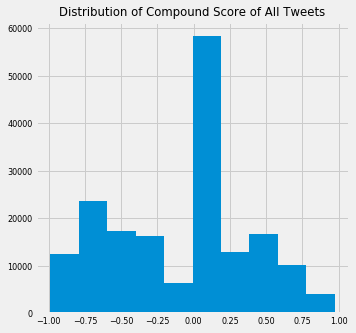

In [63]:
params = {'legend.fontsize': 'x-small',
#           'figure.figsize': (15, 5),
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)

merged_df_2.hist(column='compound', figsize=(5,5))
plt.title('Distribution of Compound Score of All Tweets')

## Distribution of compound score of tweets per topic

In [64]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', -1)
    #print(x)
    return(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [65]:
#Choose the main 4 topics
four_topics = merged_df_2[merged_df_2['Dominant_Topic'].isin([5,7,8,10])]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5718c9e8>,
      dtype=object)

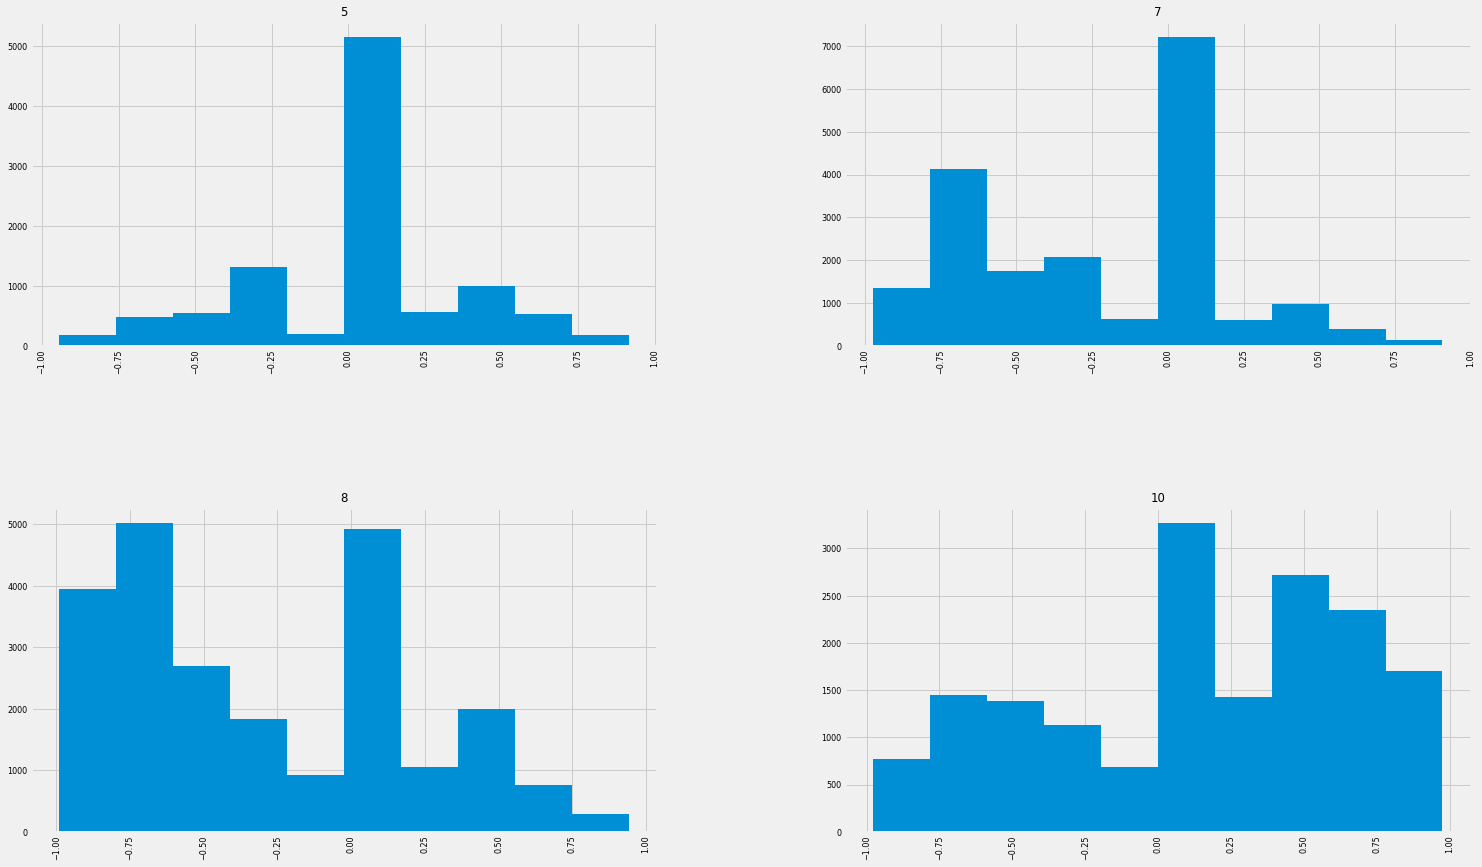

In [66]:
four_topics['compound'].hist(by=four_topics['Dominant_Topic'], figsize=(25,15))


In [67]:
four_topics['Dominant_Topic'] = four_topics['Dominant_Topic'].replace(5, 'Funeral')
four_topics['Dominant_Topic'] = four_topics['Dominant_Topic'].replace(7, 'Facts about the shooting')
four_topics['Dominant_Topic'] = four_topics['Dominant_Topic'].replace(8, 'Racism')
four_topics['Dominant_Topic'] = four_topics['Dominant_Topic'].replace(10, 'Solidarity & Justice')

//anaconda/envs/coms007/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
//anaconda/envs/coms007/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/envs/coms007/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

## Time series of  sentiment scores of tweets per day per topic

In [68]:
sentiments_df = four_topics.copy()
pivoted_df = pd.pivot_table(sentiments_df, index= 'day_of_tweet', columns= 'Dominant_Topic', values= "compound")

Text(0, 0.5, 'compound score')

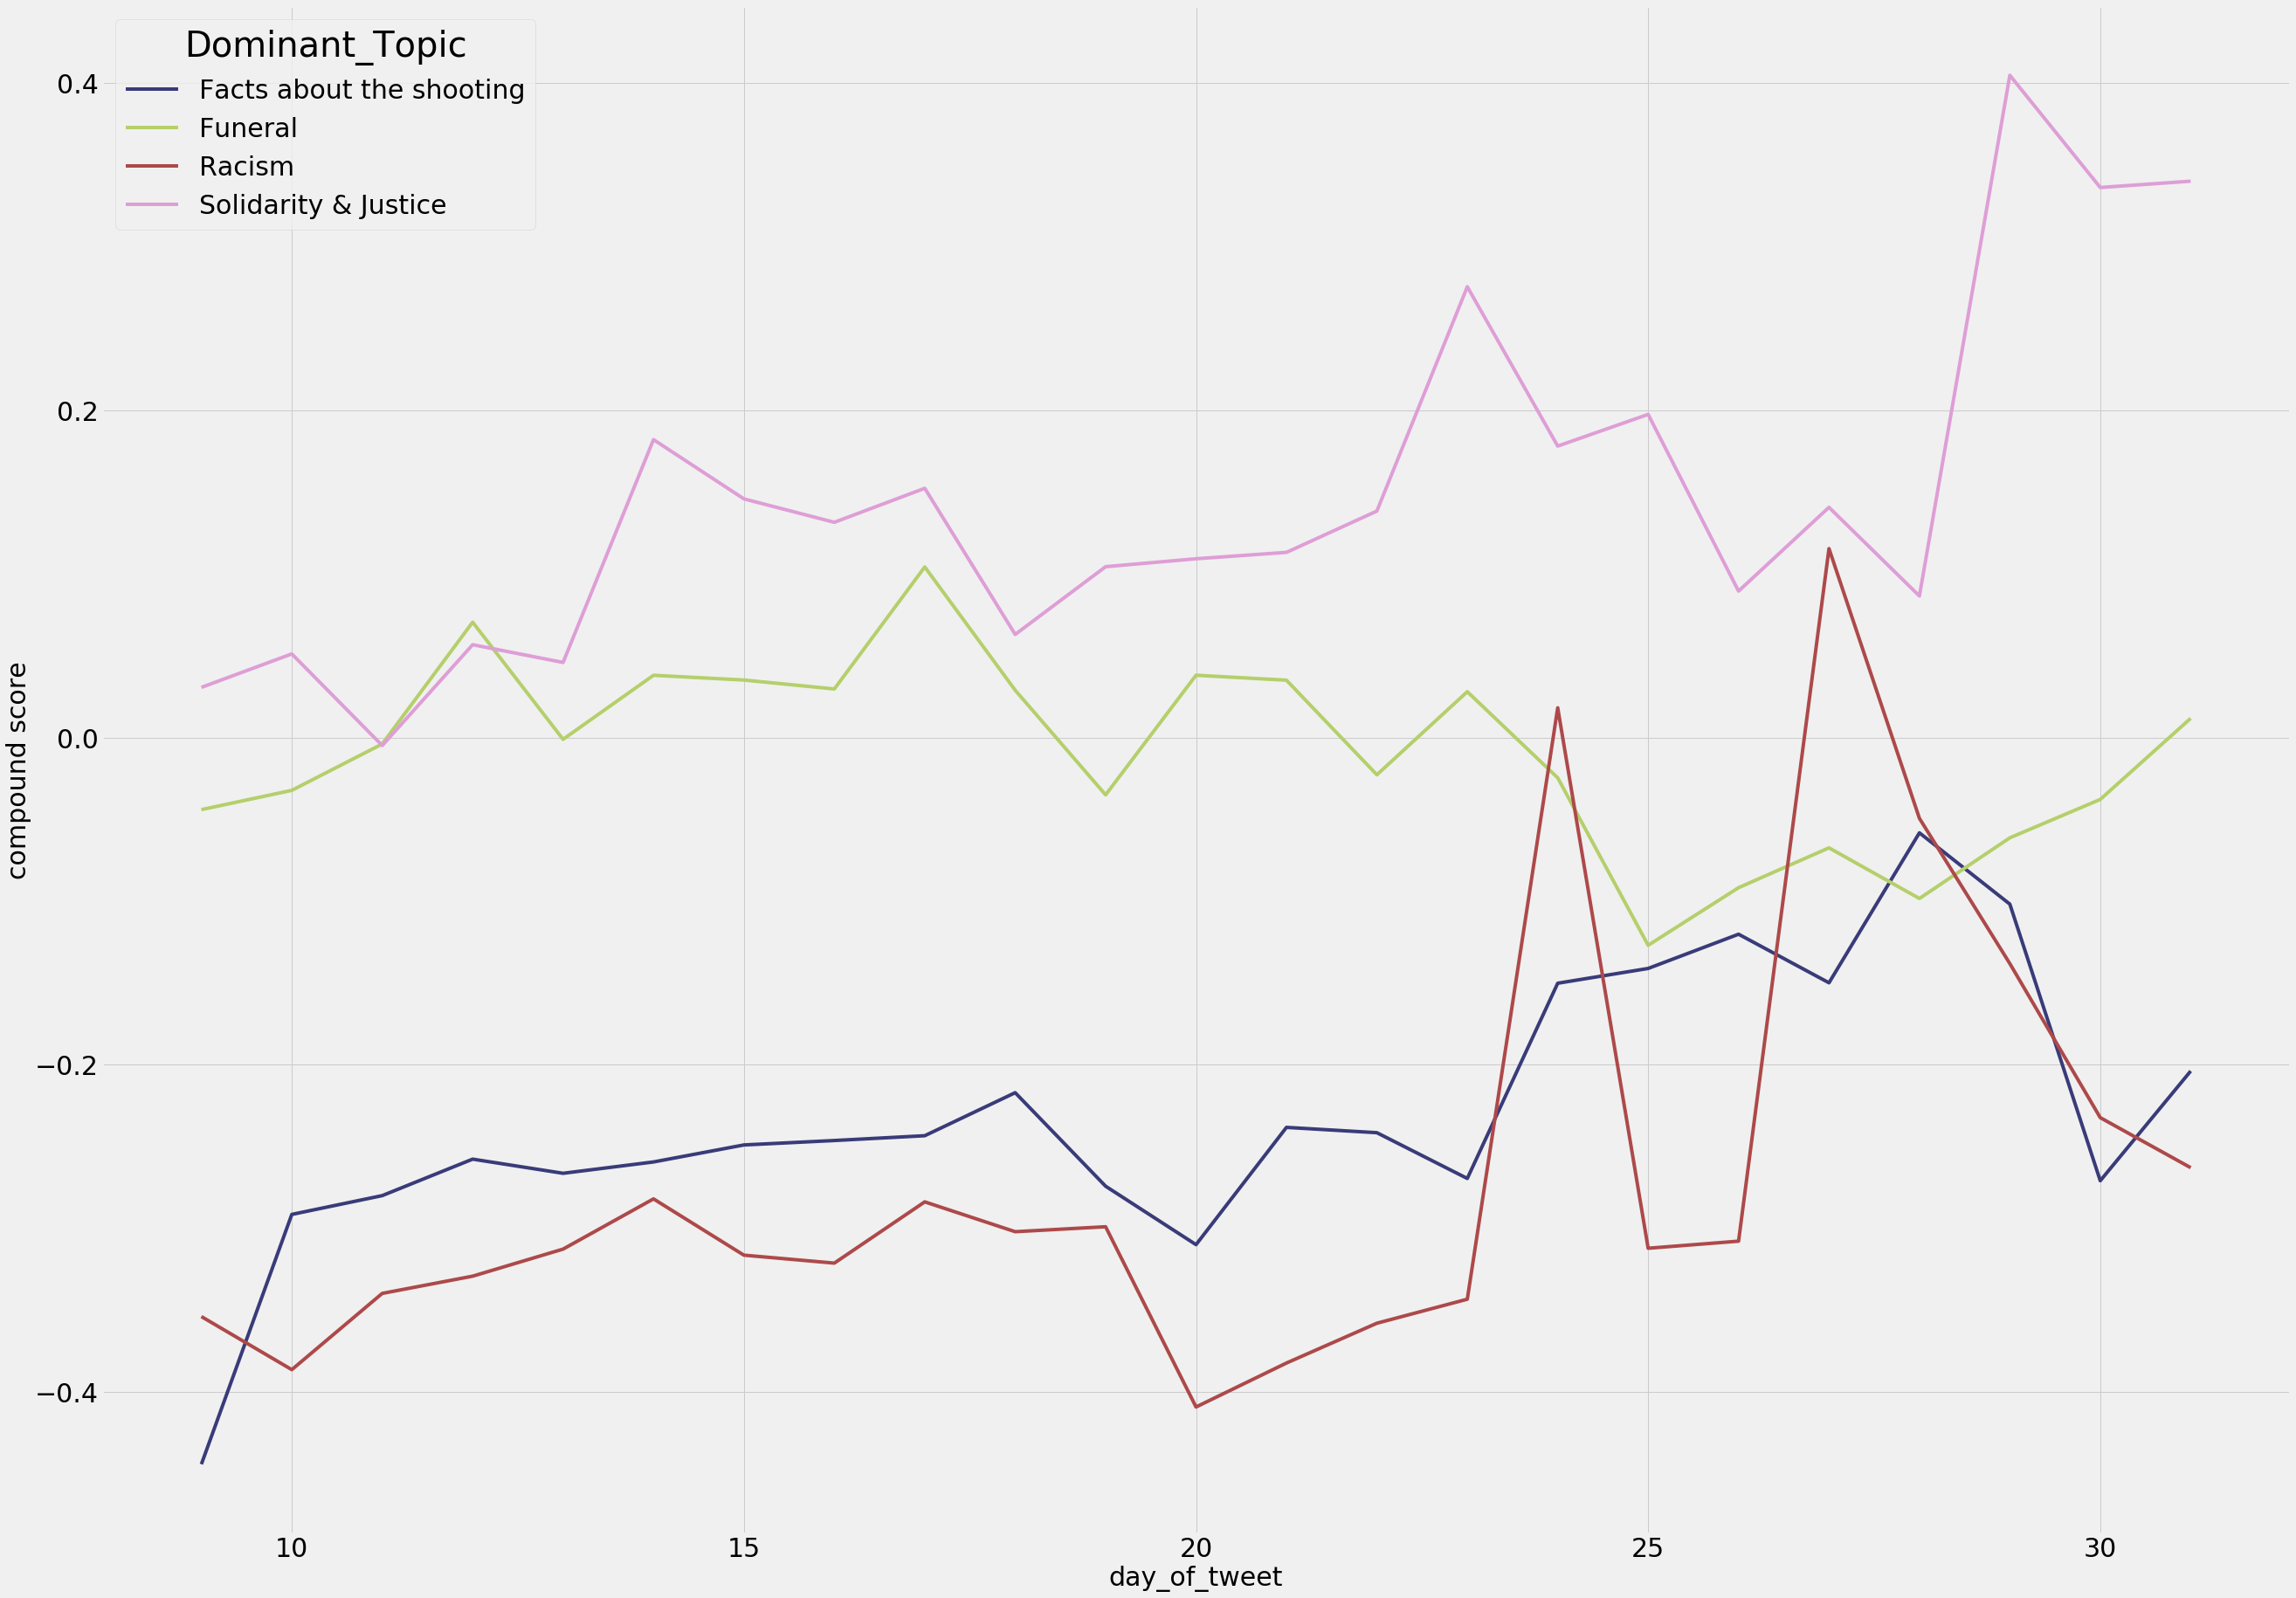

In [89]:
params = {'legend.fontsize': '30',
          'legend.title_fontsize':40,
#           'figure.figsize': (15, 5),
         'axes.labelsize': '30',
         'axes.titlesize':'50',
         'xtick.labelsize':'30',
         'ytick.labelsize':'30'}
pylab.rcParams.update(params)
pivoted_df.plot(figsize=(40,30), colormap='tab20b', grid=True)
plt.ylabel("compound score")


Text(0, 0.5, 'compound score')

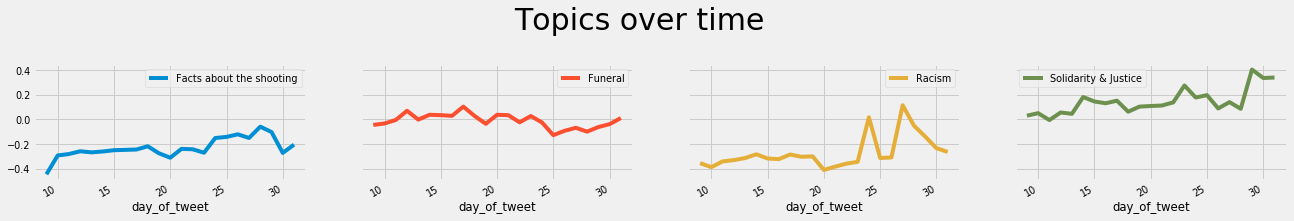

In [70]:
params = {'legend.fontsize': 'x-small',
#           'figure.figsize': (15, 5),
         'axes.labelsize': 'small',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}
pylab.rcParams.update(params)
pivoted_df.plot(subplots=True,figsize=(20,8), sharey=True, grid=True, layout=(3,4), title = 'Topics over time')
plt.ylabel("compound score")


## Distribution of sentiment across topics

In [71]:
four_topics.groupby('Dominant_Topic').compound.mean()


Dominant_Topic
Facts about the shooting   -0.238987
Funeral                    -0.008739
Racism                     -0.299053
Solidarity & Justice        0.127307
Name: compound, dtype: float64

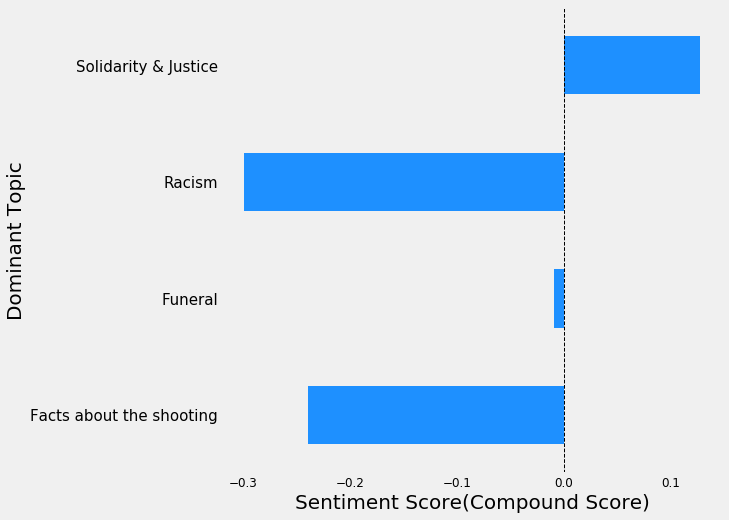

In [73]:
params = {'legend.fontsize': 'x-small',
          'figure.titlesize':30,
          
          'figure.figsize': (8, 8),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':12,
         'ytick.labelsize':15}
pylab.rcParams.update(params)

data = four_topics.groupby('Dominant_Topic').compound.mean()
data.plot.barh(grid=False, color='dodgerblue')
plt.xlabel('Sentiment Score(Compound Score)')
plt.ylabel('Dominant Topic')

plt.axvline(x=0.0, color='k', linestyle='--', linewidth=1)


Text(0, 0.5, 'compound score')

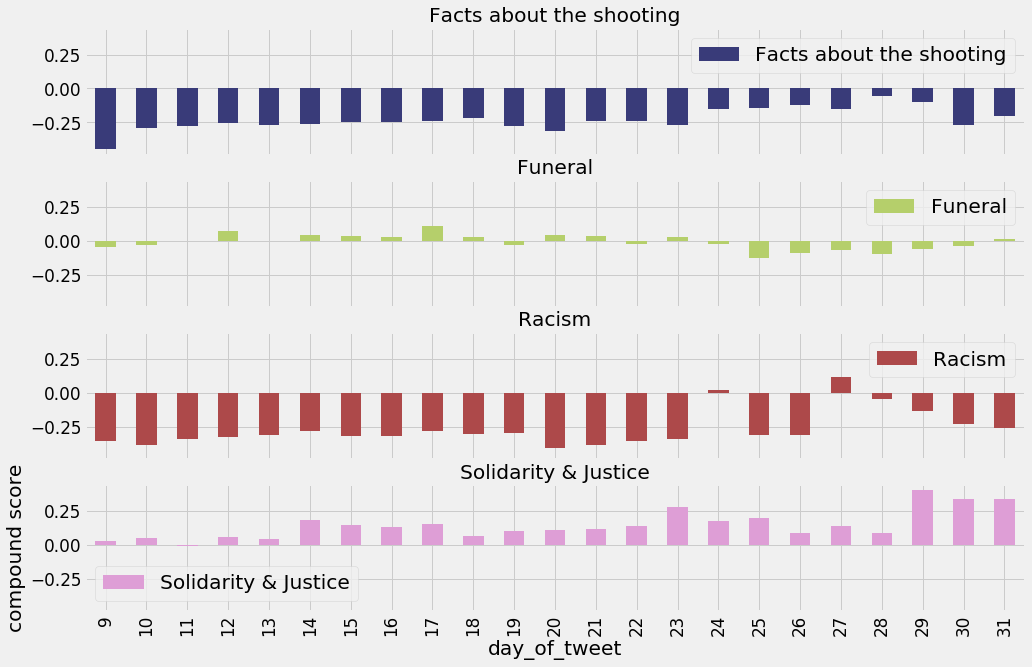

In [74]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
pivoted_df.plot.bar(colormap='tab20b', grid=True,linewidth=3, subplots = True, sharey=True, legend = 'lower right')
plt.ylabel("compound score")


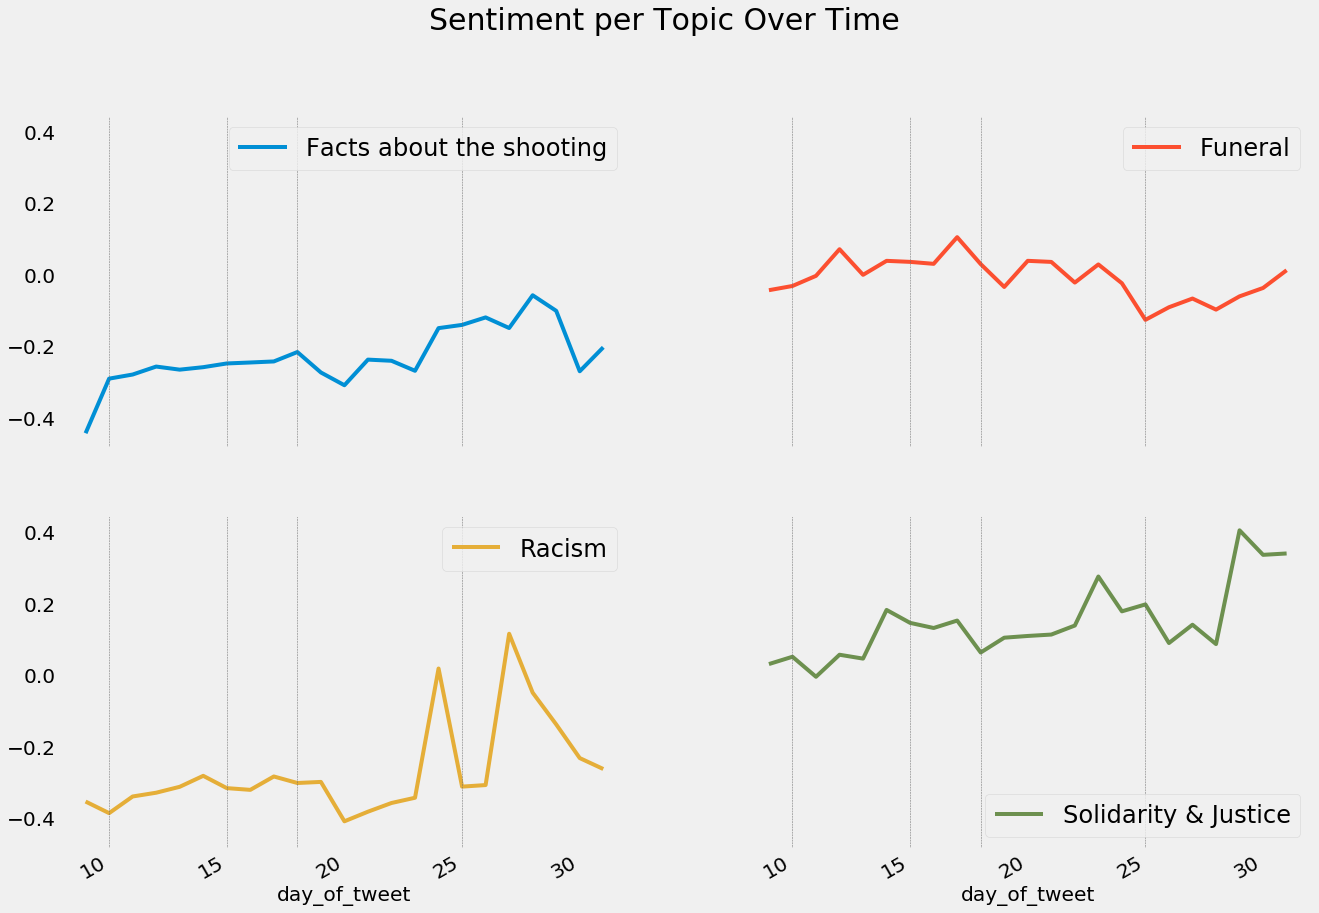

In [76]:
events = {'Protests begin': 10,
          #'Protests (Don't shoot)': 12,
          "Officer's name is released": 15,
          #'State of Emergency declaration': 16,
          'National Guard ordered into Ferguson': 18,
          #'National Guard withdrawn': 21,
          'Funeral of Michael Brown': 25
         } 

params_topics = {'legend.fontsize': 'xx-large',
                 'figure.titlesize':30,
          'figure.figsize': (20,15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':20,
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
                 'axes.grid':False,}
pylab.rcParams.update(params_topics)
p = pivoted_df.plot(subplots=True, sharey=True,layout=(2,2), title = 'Sentiment per Topic Over Time')
ps = p.flatten()
for psi in ps:
    for event, day in events.items():
        psi.axvline(x=day,  lw=0.5, color='dimgrey', linestyle='dashed')


## Time series of sentiment scores

Note:

   Pos, Neg, neu are proportion of text that falls in each category

   Compound is a score between [-1, 1]

In [77]:
sentiments_df_by_day = sentiments_df.groupby(sentiments_df.day_of_tweet)['compound'].mean()


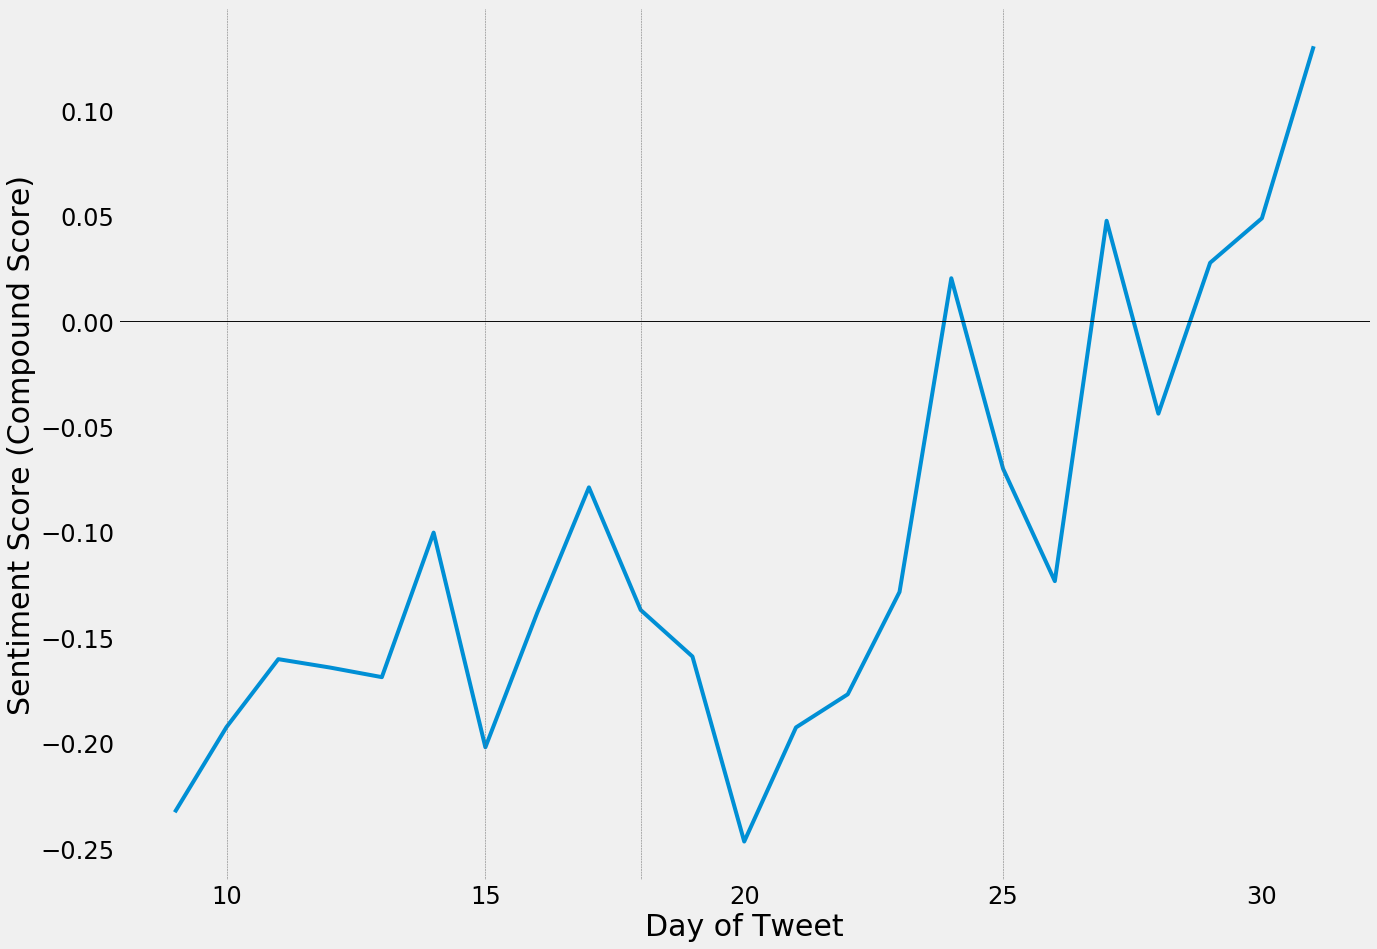

In [78]:
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (20,15),
         'axes.labelsize': 30,
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
                  'axes.grid.axis':'x'
}
pylab.rcParams.update(params)
p = sentiments_df_by_day.plot()
plt.ylabel('Sentiment Score (Compound Score)')
plt.xlabel('Day of Tweet')

for event, day in events.items():
    p.axvline(x=day,  lw=0.5, color='dimgrey', linestyle='dashed')
    p.axhline(y=0.0, color='black',lw=0.5)